In [1]:
import torch 
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
from topofm import *

torch.set_default_dtype(torch.float64)

# Bridge

In [2]:
with torch.inference_mode():
    # Prepare coordinate frame 
    dim = 2
    L = torch.eye(dim)
    frame = SpectralFrame(L)

    # prepare SDE and solver 
    c = 2.0
    sigma = 0.2
    sde = HeatBMTSDE(eigenvalues=frame.eigenvalues, c=c, sigma=sigma)
    sde_solver = make_sde_solver(sde)

    # Prepare dataset 
    delta_x = torch.tensor([3.0, 0.0])
    x0 = torch.tensor([-1.0, -1.0]) + delta_x
    x1 = torch.tensor([1.0, 1.0]) + delta_x
    x0 = x0.expand(100, 2)
    x1 = x1.expand(100, 2)
    x0, x1 = frame.transform(x0, x1)

    # Sample 100 paths from x0 to x1
    control = BridgeControl(sde=sde, x1=x1)
    xt, t = sde_solver.sample_path(x0=x0, control=control)
    t_marginal = torch.tensor(0.8)
    x_marginal = sde.marginal_distribution(t=t_marginal, x0=x0[0], x1=x1[0]).sample((100,))

    xt, x_marginal = frame.inverse_transform(xt, x_marginal)

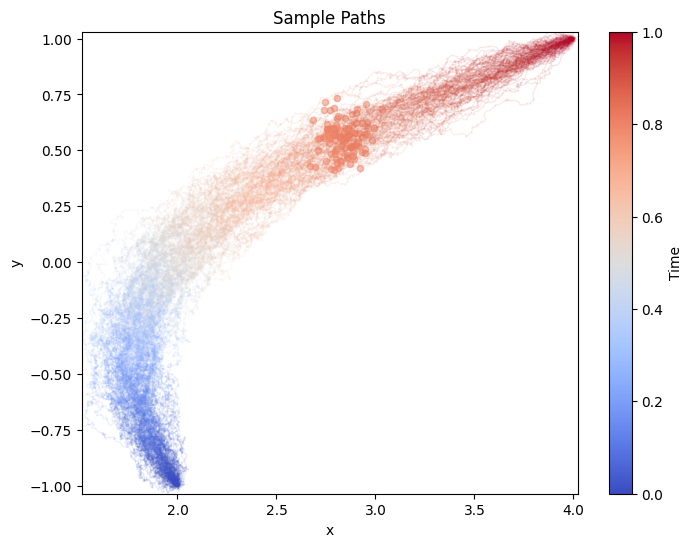

In [3]:
fig, ax = plot_trajectory(xt, t)
plot_samples(x_marginal, t=t_marginal, ax=ax);

# Optimal Transport Cost

In [4]:
# Frame 
A = torch.tensor([
    [0.0, 1.0],
    [1.0, 0.0],
])
D = torch.diag_embed(
    torch.sum(A, dim=-1),
)
L = D - A
frame = SpectralFrame(L)

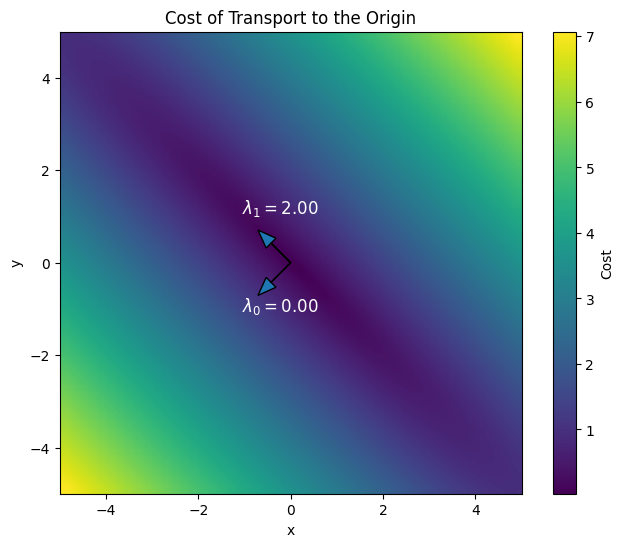

In [5]:
# Frame 
A = torch.tensor([
    [0.0, 1.0],
    [1.0, 0.0],
])
D = torch.diag_embed(
    torch.sum(A, dim=-1),
)
L = D - A
frame = SpectralFrame(L)

# Data
x1 = torch.tensor([[0.0, 0.0]])

x0_min, x0_max, n_grid = -5.0, 5.0, 50
x01 = torch.linspace(x0_min, x0_max, n_grid)
x02 = torch.linspace(x0_min, x0_max, n_grid)
x01g, x02g = torch.meshgrid(x01, x02, indexing='xy')
grid_shape = x01g.shape
x0 = torch.stack([x01g, x02g], dim=-1).reshape(-1, 2)

x1, x0 = frame.transform(x1, x0)

# SDE and solvers
c = 1.0
sigma = 0.0
sde = HeatBMTSDE(frame.eigenvalues, c=c, sigma=sigma)
ot_solver = OTSolver(sde=sde)
costs = ot_solver.cost(x0, x1).reshape(grid_shape)

x1, x0 = frame.inverse_transform(x1, x0)

# Plot the cost as a heatmap and x1 point
plt.figure(figsize=(8, 6))
ax = plt.gca()
im = ax.imshow(costs, extent=[x0_min, x0_max, x0_min, x0_max], cmap='viridis', origin='lower', interpolation='bessel')
plt.colorbar(im, ax=ax, label='Cost')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Cost of Transport to the Origin')

# Plot eigenvectors as arrows with length proportional to their eigenvalues, centered at the origin
eigenvectors = frame.U  # shape: (n, n)
eigenvalues = frame.D  # shape: (n, n), diagonal matrix of eigenvalues
label_offset = 1.5

for i, (eigenvector, eigenvalue) in enumerate(zip(eigenvectors, eigenvalues)):
    arrow = x1[0]
    eigenvalue = eigenvalue.item()
    ax.arrow(arrow[0], arrow[1], eigenvector[0], eigenvector[1], head_width=0.3, head_length=0.4, length_includes_head=True, label=f"eig {i}: {eigenvalue:.2f}")
    ax.text((arrow[0] + eigenvector[0]) * label_offset, (arrow[1] + eigenvector[1]) * label_offset, f"$\\lambda_{i}={eigenvalue:.2f}$", fontsize=12, color='white')

plt.show()

# Optimal transfer plan and the induced linear flow

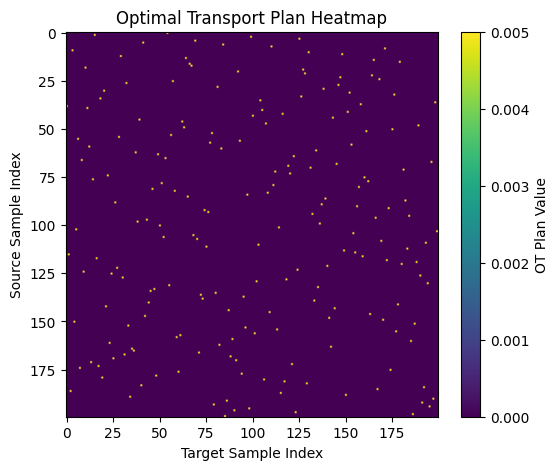

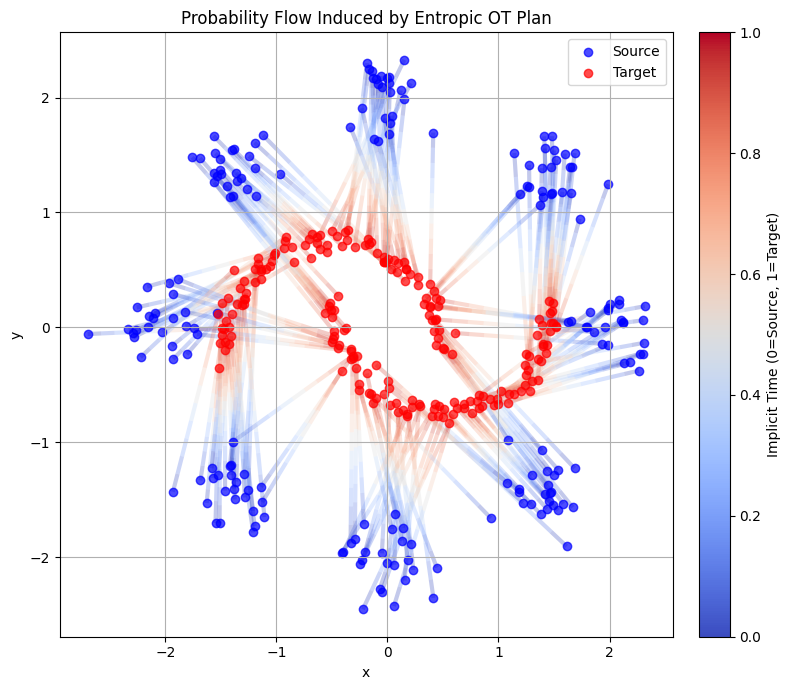

In [6]:
n = 200
x0 = EightGaussians().sample((n,))
x1 = Moons().sample((n,))

x0, x1 = frame.transform(x0, x1)
ot_plan = ot_solver.solve(x0, x1)
x0, x1 = frame.inverse_transform(x0, x1)


plt.figure(figsize=(6, 5))
plt.imshow(ot_plan.cpu(), aspect='auto', cmap='viridis')
plt.colorbar(label='OT Plan Value')
plt.title('Optimal Transport Plan Heatmap')
plt.xlabel('Target Sample Index')
plt.ylabel('Source Sample Index')
plt.show()



# Ensure x0, x1, and ot_plan are on CPU and convert to numpy arrays
x0_np = x0.cpu().numpy() if hasattr(x0, "cpu") else x0.numpy()
x1_np = x1.cpu().numpy() if hasattr(x1, "cpu") else x1.numpy()
ot_plan_np = ot_plan.cpu().numpy() if hasattr(ot_plan, "cpu") else ot_plan.numpy()

# (Assume x0_np, x1_np, ot_plan_np are already CPU NumPy arrays.)
n = x0_np.shape[0]

plt.figure(figsize=(8, 7))
ax = plt.gca()
ax.scatter(x0_np[:, 0], x0_np[:, 1],
           color='blue', label='Source', alpha=0.7)
ax.scatter(x1_np[:, 0], x1_np[:, 1],
           color='red',  label='Target', alpha=0.7)

# parameters
max_plan = ot_plan_np.max()
threshold = 0.01 * max_plan

cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=0, vmax=1)

segments = []
colors = []
widths = []

# how many sub‐segments per arrow
n_sub = 10

for i in range(n):
    for j in range(n):
        w = ot_plan_np[i, j]
        if w <= threshold:
            continue

        start = x0_np[i]
        end = x1_np[j]
        # generate equally‐spaced points along the line
        pts = np.linspace(start, end, n_sub + 1)

        # line thickness & overall alpha from flow magnitude
        flow = w / max_plan
        lw = 0.5 + 2.5 * flow
        alpha = flow * 0.3

        # build each tiny segment
        for k in range(n_sub):
            seg_t = [pts[k], pts[k + 1]]
            t = k / n_sub  # 0 at source, 1 at target
            # pick color from cmap and inject our α
            r, g, b, _ = cmap(norm(t))
            colors.append((r, g, b, alpha))
            widths.append(lw)
            segments.append(seg_t)

# assemble the LineCollection
lc = LineCollection(segments,
                    colors=colors,
                    linewidths=widths,
                    zorder=0)
ax.add_collection(lc)

# add colorbar for “time” scale
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(np.linspace(0, 1, 100))   # dummy array
cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Implicit Time (0=Source, 1=Target)')

ax.set(title='Probability Flow Induced by Entropic OT Plan',
       xlabel='x', ylabel='y')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Synthetic Experiments

## Simple 2d example

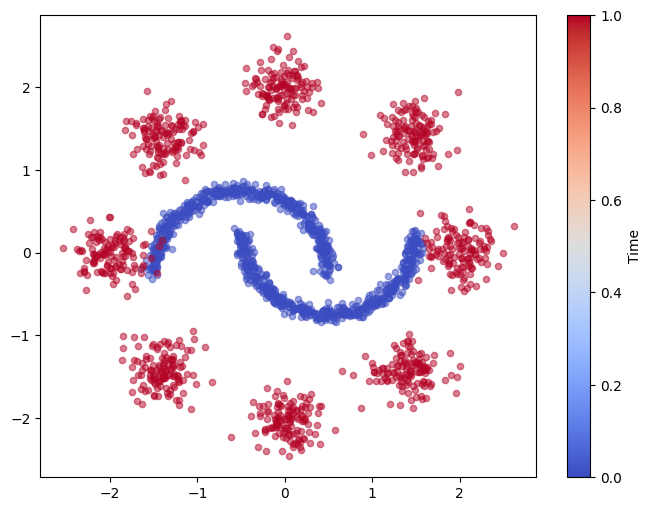

In [7]:
n = 1000
x0 = Moons().sample((n,))
x1 = EightGaussians().sample((n,))
fig, ax = plot_samples(x0, t=0.0, add_colorbar=True)
plot_samples(x1, t=1.0, ax=ax);

In [8]:
# Frame 
A = torch.tensor([
    [0.0, 1.0],
    [1.0, 0.0],
])
D = torch.diag_embed(
    torch.sum(A, dim=-1),
)
L = D - A
frame = SpectralFrame(L)

# SDE and Solvers 
sigma = 0.0
c = 2.0
sde = HeatBMTSDE(frame.eigenvalues, c=c, sigma=sigma)
ot_solver = OTSolver(sde=sde)

# dataset
x0_distribution = EightGaussians()
x1_distribution = Moons() 
dataset = MatchingDistributionDataset(
    x0_distribution, 
    x1_distribution, 
)

batch_size = 512
num_batches = 50 * 512 // batch_size
train_data_loader = MatchingDataLoader(
    dataset=dataset, 
    batch_sampler=OTBatchSampler(
        dataset=dataset, 
        ot_solver=ot_solver, 
        batch_size=batch_size, 
        num_batches=num_batches,
        batchwise_ot=False, 
    ),
)
eval_data_loader = MatchingDataLoader(
    dataset=dataset, 
    batch_sampler=OTBatchSampler(
        dataset=dataset, 
        ot_solver=ot_solver, 
        batch_size=512, 
        num_batches=1,
        batchwise_ot=False, 
    ),
)

# model and training 
model = ResidualNN(data_dim=2)

num_epochs = 1000 // num_batches // 10 #* 5
history = fit(
    sde=sde, 
    model=model, 
    train_data_loader=train_data_loader, 
    eval_data_loader=eval_data_loader,
    num_epochs=num_epochs,

)
plot_history(history)

Epochs: 100%|██████████| 2/2 [00:17<00:00,  8.60s/it, W1=0.339, W2=0.308, loss=0.00155]


(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Sample Paths with Time-varying Color (Blue→Red, Fixed Alpha)'}, xlabel='x[0]', ylabel='x[1]'>)

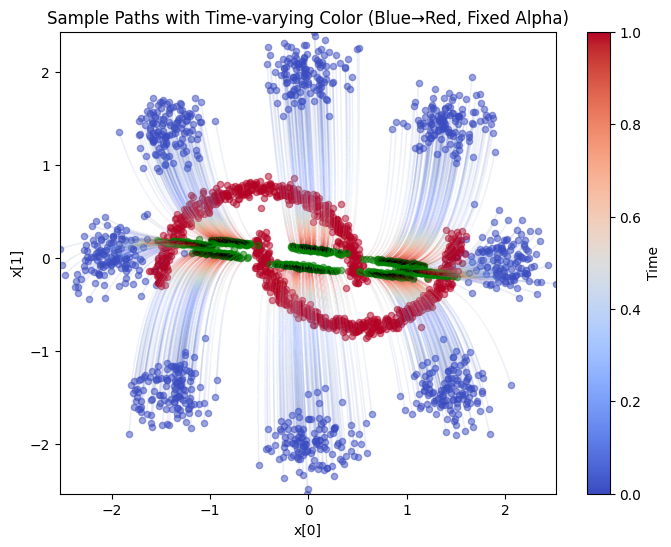

In [ ]:
with torch.inference_mode():
    control = ModelControl(model)
    sde_solver = make_sde_solver(sde)
    n_test = 1024
    x0, x1 = dataset.sample((n_test,))
    xt, t = sde_solver.sample_path(x0, control=control)
    x0, xt, x1 = dataset.frame.inverse_transform(x0, xt, x1)


def plot_predictions_2d(
    t: torch.Tensor,
    xt: torch.Tensor,
    x0: torch.Tensor,
    x1: torch.Tensor
) -> tuple[plt.Figure, plt.Axes]:
    """
    Plot predicted sample paths and endpoints.

    Args:
        t: Time steps tensor.
        xt: Trajectory tensor of shape (N, T, 2).
        x0: Initial samples tensor.
        x1: Target samples tensor.

    Returns:
        Tuple of (figure, axes) from matplotlib.
    """
    fig, ax = plot_trajectory(xt, t)
    plot_samples(x0, t=0.0, ax=ax)
    plot_samples(x1, t=1.0, ax=ax)
    plot_samples(xt[:, -1], color='green', label='predicted', ax=ax)
    return fig, ax

# Brain Connectome Experiment

In [ ]:
# settings 
c = 2.0
sigma = 0.0
normalize_variance = False 
batch_size = 512 
num_batches = 20 * 512 // batch_size 
num_epochs = 20000 // num_batches
batchwise_ot = False

# Data
L, x0, x1, x0_train, x0_test, x1_train, x1_test = as_tensors(*load_brain_data())

# Frame, SDE, and solvers 
frame = SpectralFrame(L)
sde = HeatBMTSDE(frame.eigenvalues, c=c, sigma=sigma)

# Dataloaders
train_dataset = MatchingTensorDataset(
    x0=x0_train, 
    x1=x1_train, 
    frame=frame,
)
eval_dataset = MatchingTensorDataset(
    x0=x0_eval, 
    x1=x1_eval, 
    frame=frame,
)
train_data_loader = MatchingDataLoader(
    dataset=dataset, 

)

# Model 
model = ResidualNN(data_dim=x0.shape[-1])

batch_size = 64
num_batches = 20 * 512 // batch_size
num_epochs = 20000 // num_batches 

history = fit(
    sde=sde, 
    model=model, 
    train_data_loader=train_data_loader, 
    eval_data_loader=eval_data_loader, 
    num_epochs=num_epochs,
)

training_losses = train(
    sde=sde, 
    ot_solver=ot_solver, 
    model=model, 
    dataset=dataset, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    num_batches=num_batches, 
    lr=lr, 
    batchwise_ot=batchwise_ot,
)
px.line(training_losses)

Epochs:   0%|          | 0/125 [00:00<?, ?it/s]

: 

In [ ]:
sde_solver = EulerMaruyamaSolver(sde=sde, n=num_timesteps)
with torch.no_grad():
    x0_test_pred = sde_solver.sample_from_terminal(x0=x0_test, control=ModelControl(model))
    test_w1 = wasserstein_distance(x0_test_pred, x1_test, p=1)
    test_w2 = wasserstein_distance(x0_test_pred, x1_test, p=2)

print(f"Wasserstein-1 distance: {test_w1:.4f}")
print(f"Wasserstein-2 distance: {test_w2:.4f}")

plot_brain_signal_2d(x0_test[0]);
plot_brain_signal_2d(x0_test_pred[0]);
plot_brain_signal_2d(x1_test[0]);

Wasserstein-1 distance: 21.9974
Wasserstein-2 distance: 15.6121
